T-test p-value: 0.86375


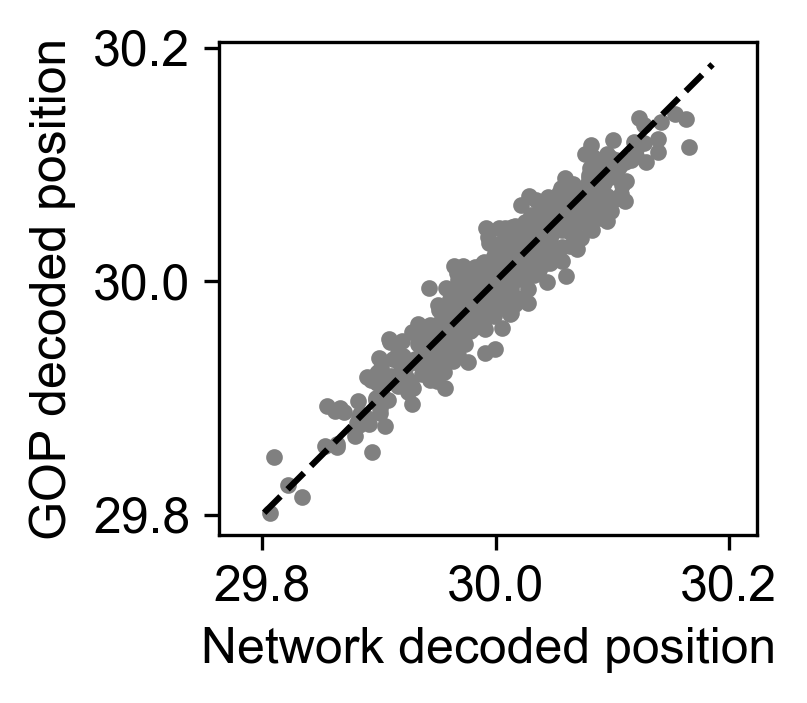

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Network_bayesian import Place_net, Grid_net, Coupled_Net
import brainpy as bp
import brainpy.math as bm
from matplotlib.animation import FuncAnimation
import time
from scipy.stats import ttest_ind, norm
import seaborn as sns

# 保存数据为npz文件
data = np.load('data/distribution_results.npz') # 500 tials
z_decode_gop = data['z_decode_gop']
z_decode_net = data['z_decode_net']
# z_decode_net_motion = data['z_decode_net_motion'] # 不适用，因为这里的z_decode_net_motion和z_decode_net_visual是单独的网络的结果
# z_decode_net_visual = data['z_decode_net_visual']

# 计算t-test结果并输出p值
t_stat, p_value = ttest_ind(z_decode_gop, z_decode_net)
print(f"T-test p-value: {p_value:.5f}")

# 设置字体
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# 画图
plt.figure(figsize=(2.8, 2.5), dpi=300)
z_decode_all = np.concatenate([z_decode_gop, z_decode_net])
min_z = np.min(z_decode_all)
max_z = np.max(z_decode_all)

plt.plot(z_decode_net, z_decode_gop, '.', color='gray')
# plt.xticks([29.8,29.9,30,30.1,30.2])
# plt.yticks([29.8,29.9,30,30.1,30.2])
plt.xticks([29.8, 30, 30.2])
plt.yticks([29.8, 30, 30.2])
plt.plot([min_z, max_z+0.02], [min_z, max_z+0.02], 'k--')
plt.xlabel('Network decoded position')
plt.ylabel('GOP decoded position')
plt.axis('equal')  # 设置坐标轴比例相等
plt.tight_layout()
# plt.savefig('figures/net_gop_comparison.eps')

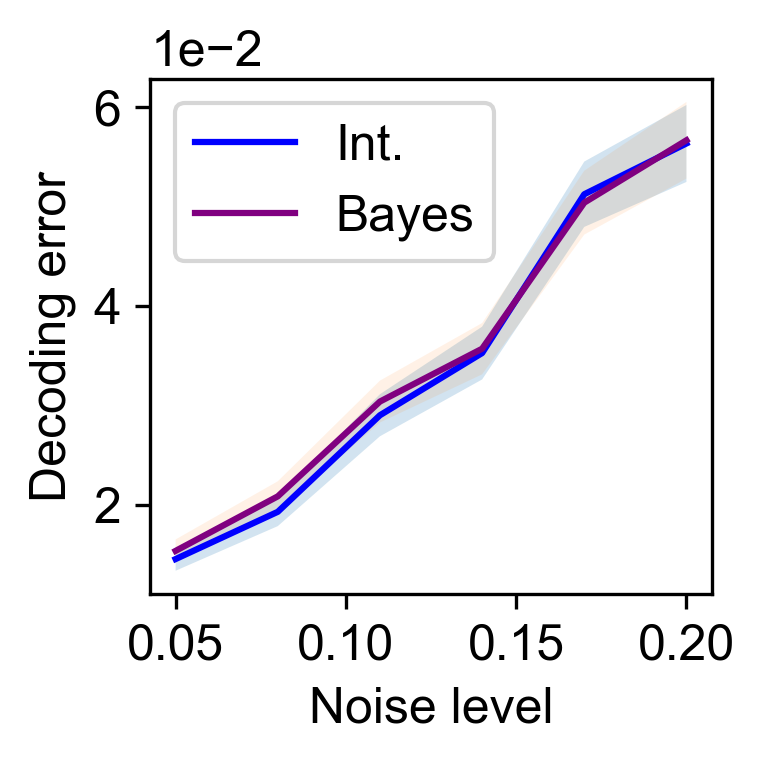

In [ ]:
# 之前的旧数据
data = np.load('data/results.npz') # 100 trials
mean_integrate_net = data['mean_integrate_net']
mean_motion_net = data['mean_motion_net']
mean_visual_net = data['mean_visual_net']
mean_integrate_gop = data['mean_integrate_gop']
std_integrate_net = data['std_integrate_net']
std_motion_net = data['std_motion_net']
std_visual_net = data['std_visual_net']
std_integrate_gop = data['std_integrate_gop']

n_stre = 6
noise_stre = np.linspace(0.05, 0.2, n_stre)

plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# 自定义颜色
colors = ['#2196F3', '#d62728', '#2ca02c', '#9467bd']

# 画图
plt.figure(figsize=(2.7, 2.7), dpi=300)
# plt.plot(noise_stre, mean_motion_net, '-o', label='Mot.', color=colors[0])
# plt.fill_between(noise_stre, mean_motion_net - std_motion_net/10, mean_motion_net + std_motion_net/10, alpha=0.2)

# plt.plot(noise_stre, mean_visual_net, '-o', label='Env.', color=colors[1])
# plt.fill_between(noise_stre, mean_visual_net - std_visual_net/10, mean_visual_net + std_visual_net/10, alpha=0.2)

plt.plot(noise_stre, mean_integrate_net, label='Int.', color='blue')
plt.fill_between(noise_stre, mean_integrate_net - std_integrate_net/10, mean_integrate_net + std_integrate_net/10, alpha=0.2)

plt.plot(noise_stre, mean_integrate_gop, label='Bayes', color='purple')
plt.fill_between(noise_stre, mean_integrate_gop - std_integrate_gop/10, mean_integrate_gop + std_integrate_gop/10, alpha=0.1)

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel('Noise level')
plt.ylabel('Decoding error')
plt.legend()

plt.xticks([0.05, 0.1, 0.15, 0.2])
plt.yticks([0.02, 0.04, 0.06])

plt.tight_layout()
# plt.savefig('figures/Bayesian_integration.eps')
plt.show()


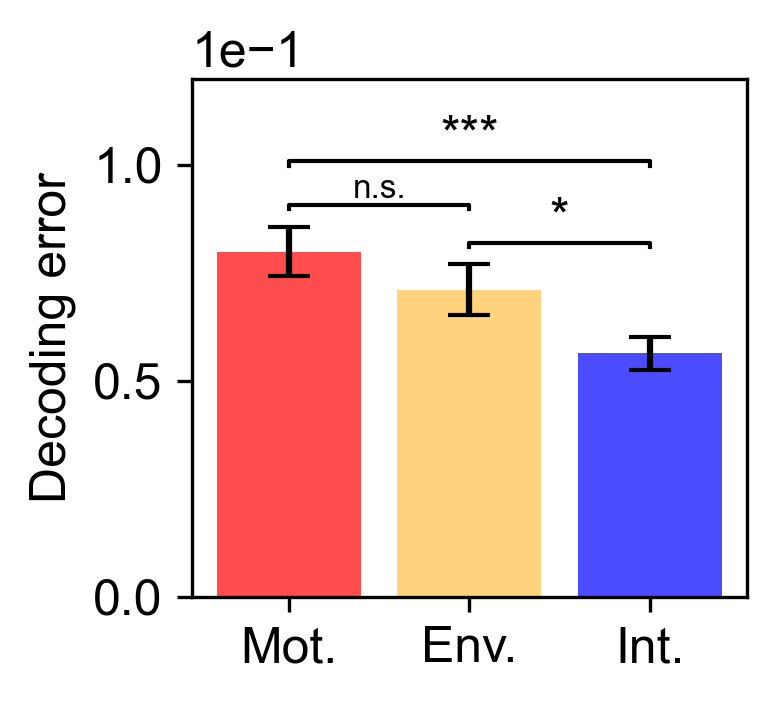

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# 计算 noise=0.2 时的索引
idx = np.where(np.isclose(noise_stre, 0.2))[0][0]

# 提取三种网络在 noise=0.2 时的均值和标准差
mean_errors = [
    mean_motion_net[idx],
    mean_visual_net[idx],
    mean_integrate_net[idx]
]
std_errors = [
    std_motion_net[idx],
    std_visual_net[idx],
    std_integrate_net[idx]
]
labels = ['Mot.', 'Env.', 'Int.']
# colors = ['#ffc048', '#05c46b', '#2196F3']
colors = ['red', '#ffc048', 'blue']

# 假设每组样本量相同（n=10，需替换为实际值）
n = 100

# 执行配对 t 检验（假设数据是配对的，如相同噪声条件下的多次实验）
p_values = []
comparisons = [(0, 1), (0, 2), (1, 2)]  # 比较 Mot vs Env, Mot vs Int, Env vs Int

for i, j in comparisons:
    t_stat, p_val = stats.ttest_ind_from_stats(
        mean1=mean_errors[i], std1=std_errors[i], nobs1=n,
        mean2=mean_errors[j], std2=std_errors[j], nobs2=n
    )
    p_values.append(p_val)

# 绘制柱状图
plt.figure(figsize=(2.75, 2.5), dpi=300)
yerr = [
    std_motion_net[idx]/10,
    std_visual_net[idx]/10,
    std_integrate_net[idx]/10
]
bars = plt.bar(range(3), mean_errors, yerr=yerr, color=colors, alpha=0.7, capsize=5)
plt.xticks(range(3), labels)
plt.ylabel('Decoding error')
plt.yticks([0, 0.05, 0.1])
plt.ylim(0, 0.12)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.tight_layout()

# 添加显著性标注
def add_significance(i, j, p_val, y_offset=0.05):
    """在柱 i 和柱 j 之间添加显著性标记"""
    x1, x2 = i, j
    y = max(mean_errors[i], mean_errors[j]) + y_offset
    h = 0.01 * y
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c='k')
    if p_val < 0.001:
        plt.text((x1+x2)*0.5, y+h, '***', ha='center', va='bottom')
    elif p_val < 0.01:
        plt.text((x1+x2)*0.5, y+h, '**', ha='center', va='bottom')
    elif p_val < 0.05:
        plt.text((x1+x2)*0.5, y+h, '*', ha='center', va='bottom')
    else:
        plt.text((x1+x2)*0.5, y+h, 'n.s.', ha='center', va='bottom', fontsize=8)

# 标注所有比较
y_offsets = [0.01, 0.02, 0.01]  # 避免重叠
for (i, j), p_val, y_offset in zip(comparisons, p_values, y_offsets):
    add_significance(i, j, p_val, y_offset)

plt.show()